# Test the Effect of Weights
The key question to answer is: Does it make our model more transferrable to new systems?

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load in the Data and Models
The weights were produced by the previous notebook, and we'll re-use the same model from the "unweighted" strategy. We also want the channel data as a validation set

In [2]:
with open(os.path.join('..', '..', 'best_model.pkl'), 'rb') as fp:
    model = pkl.load(fp)

In [3]:
with open(os.path.join('..', '..', '..', 'featurizers.pkl'), 'rb') as fp:
    X_cols = pkl.load(fp).feature_labels()

In [4]:
train_data = pd.read_pickle(os.path.join('data', 'random_data.pkl.gz'))

In [5]:
test_data = pd.read_pickle(os.path.join('..', '..', 'data', 'channel_data.pkl.gz')).query('average_range')

## Recreate the Un-weighted Case
Re-train the model on the random data, and show its performance on the channel

In [6]:
model.fit(train_data[X_cols], train_data['force'])

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('lasso_rfe', SelectFromModel(estimator=LassoLars(alpha=1e-10, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=35, normalize=True,
     positive=False, precompute='auto...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'lasso_rfe__estimator__max_iter': range(40, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

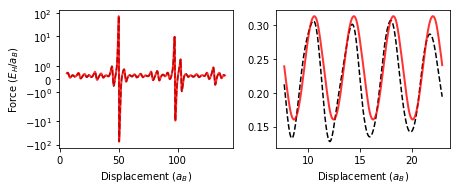

In [7]:
fig, axs = plt.subplots(1, 2)

for ax, data in zip(axs.flatten(), [train_data, test_data]):
    ax.plot(data['displacement'], data['force'], 'k--', label='TD-DFT')
    ax.plot(data['displacement'], model.predict(data[X_cols]), 'r', lw=2, alpha=0.8)
    
    ax.set_xlabel('Displacement ($a_B$)')
    
# Make it prettier
axs[0].set_yscale('symlog')
axs[0].set_ylabel('Force ($E_H / a_B$)')

fig.set_size_inches(6.5, 2.75)
fig.tight_layout()

*Finding*: Our model does work fairly well. But, we do overestimate the stopping power of the channel

## Explore the Effect of Weighting
To measure how the weighting effects transferrability, we will explore how the model performance on both the "training" and "test" sets are affected by increasing the weighting. For model performance, we will measure the MAE of the models and the average stopping power

In [8]:
results = []
for strength in np.linspace(0, 1, 16):
    # Gradually turn on the weights
    weights = np.exp(strength * np.log(train_data['kde_weight']))
    
    # Re-train the model with weights
    model.fit(train_data[X_cols], train_data['force'], model__sample_weight=weights)
    
    # Run the model on the training and test sets
    train_pred = model.predict(train_data[X_cols])
    test_pred = model.predict(test_data[X_cols])
    
    # Evaluate model performance
    results.append({
        'max_over_average': np.max(weights) / np.mean(weights),
        'weight_strength': strength,
        'random_stopping': np.mean(train_pred),
        'channel_stopping': np.mean(test_pred),
        'random_mae': mean_absolute_error(train_pred, train_data['force']),
        'channel_mae': mean_absolute_error(test_pred, test_data['force'])
    })
results = pd.DataFrame(results)

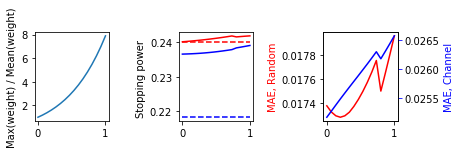

In [9]:
fig, axs = plt.subplots(1, 3)

# Plot the dispersity of weights
axs[0].plot(results['weight_strength'], results['max_over_average'])
axs[0].set_ylabel('Max(weight) / Mean(weight)')

# Plot the effect of weighting
axs[1].plot([0, 1], [train_data['force'].mean()] * 2, 'r--')
axs[1].plot([0, 1], [test_data['force'].mean()] * 2, 'b--')
axs[1].plot(results['weight_strength'], results['random_stopping'], 'r')
axs[1].plot(results['weight_strength'], results['channel_stopping'], 'b')
axs[1].set_ylabel('Stopping power ')

# Plot the MAEs
axs[2].plot(results['weight_strength'], results['random_mae'], 'r')
axs[2].set_ylabel('MAE, Random', color='r')
axs_split = axs[2].twinx()
axs_split.plot(results['weight_strength'], results['channel_mae'], 'b')
axs_split.tick_params('y', color='b')
axs_split.set_ylabel('MAE, Channel', color='b')

fig.set_size_inches(6.5, 2)
fig.tight_layout()

*Finding*: Stronger weighting makes both models worse. Both in the stopping powers being less accurate and the MAEs being higher. 

Thoughts: There a fair number of adjustable parameters in the weighting schemems. I might not have converged on a good one yet. Additionally, perhaps the effect of using the reweighting is really only beneficiaial when I have a _really_ imbalanced dataset (e.g., the teaching trajectory)